# Electricity dataset - evaluation

In [1]:
import sys
sys.path.insert(1, '/home/patryk_mscwrona/repos') # inserting a library's directory

from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *
from pyspark.sql.types import *
import numpy as np
import matplotlib.pyplot as plt

from river import optim
from river import linear_model
from river import forest
from river import tree
from river import ensemble
from river import preprocessing
from river import metrics
from river import dummy
from river import utils
from river import drift
import datetime as dt

import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (18, 18),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pylab.rcParams.update(params)

from Fleuve.master import stream_miner_master
from Fleuve.master import evaluator_master
from Fleuve.master import predictor_master
from Fleuve.master import drift_detector_master

# initialize credit card input
from Fleuve.evaluation.initialize_scripts.initialize_electricity import InitializeE
from Fleuve.evaluation.initialize_scripts.initialize_friedman import InitializeF




# SM1 - Electricity

In [2]:
init = InitializeE() # loading a s
spark, input_schema, sc, sdf = init.spark, init.input_schema, init.sc, init.sdf



23/08/20 21:19:38 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [5]:
#SET TASK
task = {"cluster-9e14-w-0": {"models": [dummy.NoChangeClassifier(), 
                                        tree.ExtremelyFastDecisionTreeClassifier(delta=1e-5,max_depth=20,min_samples_reevaluate=100), 
                                        forest.ARFClassifier(seed = 44, n_models = 5, max_depth = 20), 
                                        tree.HoeffdingTreeClassifier(max_depth = 20)] , 
                             "min_update_freq_s" : 60, 
                             "min_training_instances": 45000}, 
        "cluster-9e14-w-1" : {"models": [dummy.NoChangeClassifier(), 
                                        tree.ExtremelyFastDecisionTreeClassifier(delta=1e-5,max_depth=20,min_samples_reevaluate=100), 
                                        forest.ARFClassifier(seed = 44, n_models = 5, max_depth = 20), 
                                        tree.HoeffdingTreeClassifier(max_depth = 20)] , 
                             "min_update_freq_s" : 60, 
                             "min_training_instances": 45000 }, 
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000), 
                        utils.TimeRolling(metrics.Accuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.BalancedAccuracy(), period=dt.timedelta(seconds = 20)), 
                        utils.TimeRolling(metrics.F1(), period=dt.timedelta(seconds = 20)), 
                       utils.TimeRolling(metrics.CohenKappa(), period=dt.timedelta(seconds = 20))]}

data_cols = [field.name for field in input_schema.fields][:-1]
print(data_cols)
# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)
output_schema = sm.output_schema

output_schema


['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']


StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('TR_Accuracy', FloatType(), False), StructField('TR_BalancedAccuracy', FloatType(), False), StructField('TR_F1', FloatType(), False), StructField('TR_CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('TR_Accuracy_2

In [8]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/e1", "/user/hdfs/evaluation/sm/e1/chk")

23/08/20 16:04:34 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/08/20 16:07:50 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 196250 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [9]:
df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/e1")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["hash"] == "dmtxlnz2aju84ypn"]

(45311, 44)
194.59029


In [11]:
print(np.max(pdf.n)) # seconds of training
np.unique(pdf.hash, return_counts=True)

# NoChangeClassifier_cluster-9e14-w-0_109272.pkl

45311


(array(['jwhamxn9gehhmx60'], dtype=object), array([45311]))

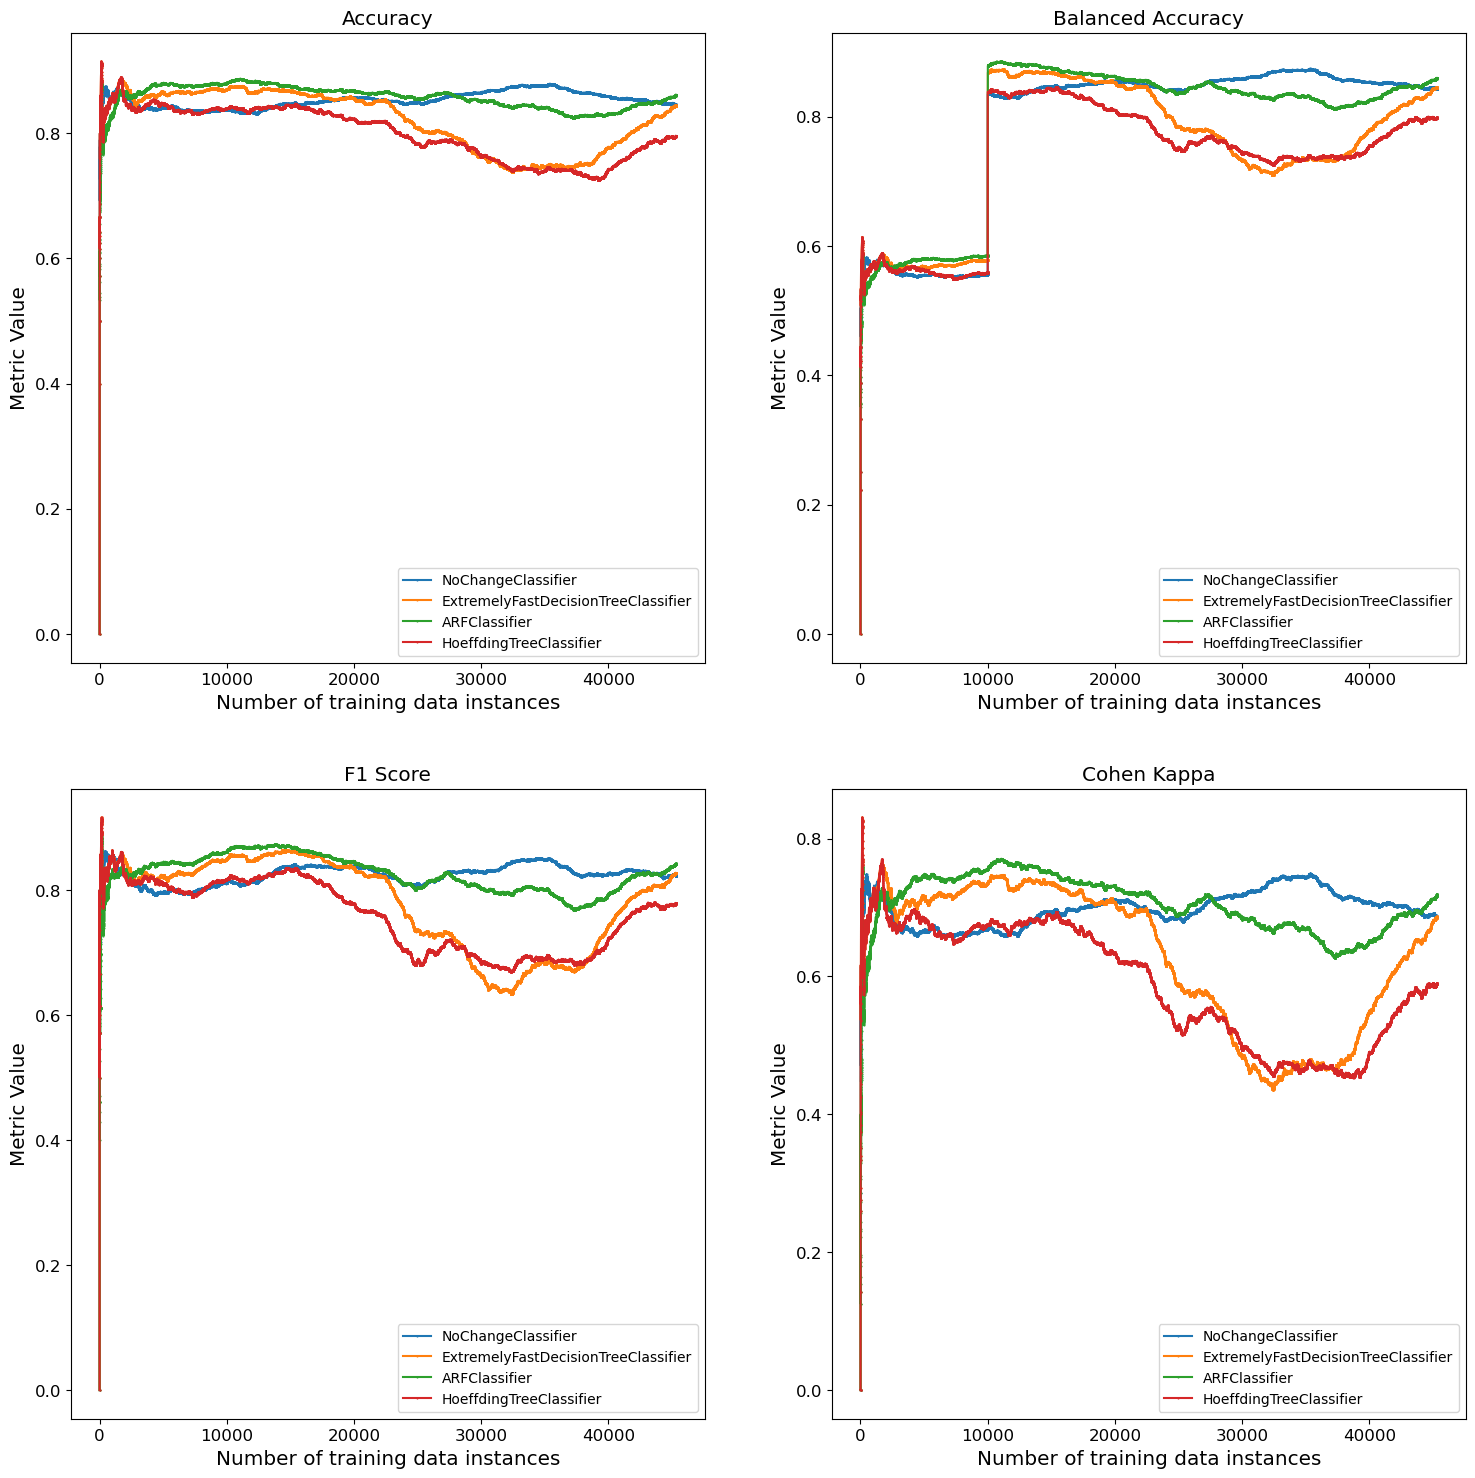

In [13]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

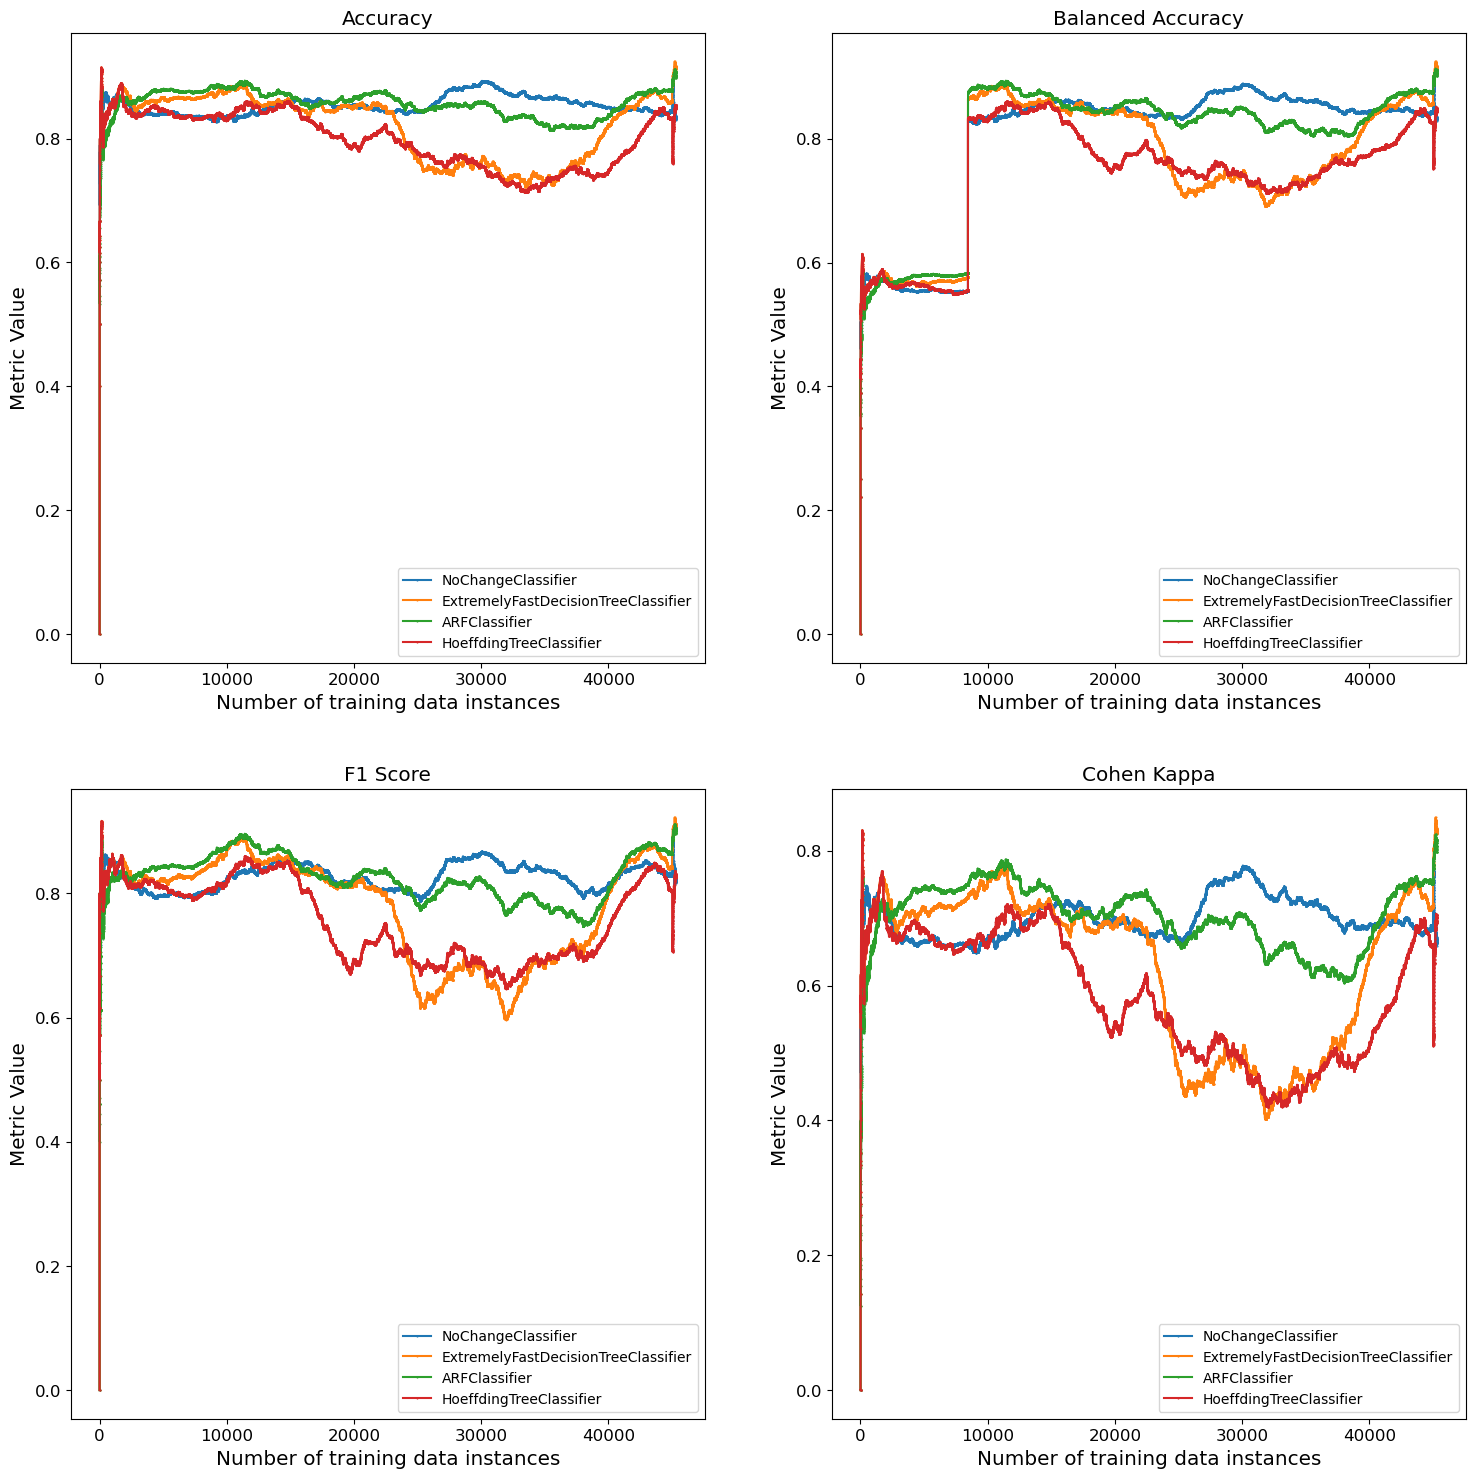

In [14]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.TR_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.TR_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.TR_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.TR_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.TR_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].TR_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].TR_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].TR_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].TR_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')

for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# SM2 - Electricity

In [15]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"
                                                  ]},
        "cluster-9e14-w-1" : {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"]},
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000)]}

data_cols = [field.name for field in input_schema.fields][:-1]
print(data_cols)
# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)
output_schema = sm.output_schema

output_schema


['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']


StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('model_name_3', StringType(), False), StructField('prediction_3', DoubleType(), False), StructField('R_Accuracy_3', FloatType(), False), StructField('R_BalancedAccuracy_3', FloatType(), False), StructField('R_F

In [16]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/e2", "/user/hdfs/evaluation/sm/e2/chk")

23/08/20 16:24:22 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/08/20 16:26:12 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 110067 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [17]:
df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/e2")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

# print(np.max(pdf.training_time)) # seconds of training

# pdf = pdf[pdf["hash"] == "dmtxlnz2aju84ypn"]

(45311, 28)
90.35795


In [18]:
print(np.max(pdf.n)) # seconds of training
np.unique(pdf.hash, return_counts=True)

# NoChangeClassifier_cluster-9e14-w-0_109272.pkl

45311


(array(['slrsfietow1tpi93'], dtype=object), array([45311]))

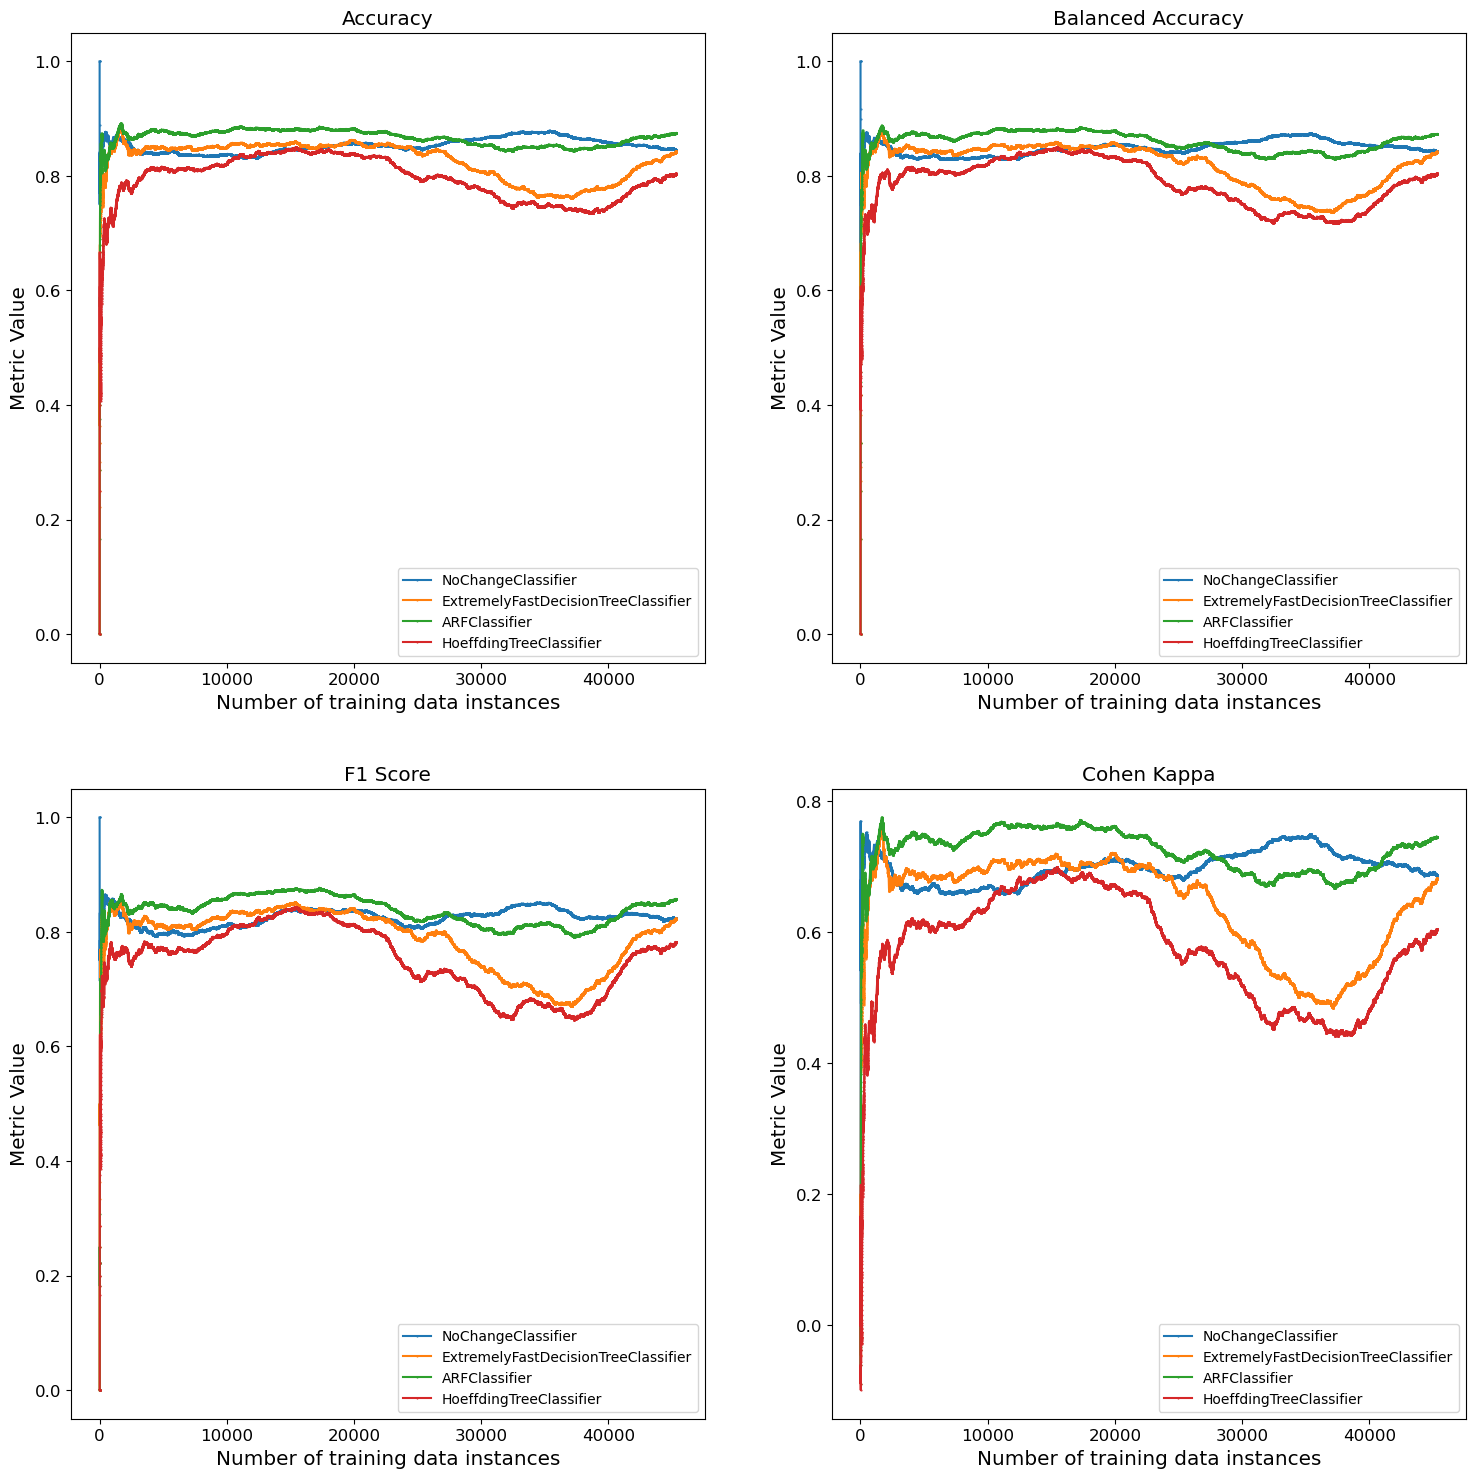

In [19]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.1].n, pdf[pdf["R_CohenKappa"] >= -0.1].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.1].n, pdf[pdf["R_CohenKappa_2"] >= -0.1].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.1].n, pdf[pdf["R_CohenKappa_3"] >= -0.1].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.1].n, pdf[pdf["R_CohenKappa_4"] >= -0.1].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of training data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

# Electricity 3 - evaluator

In [6]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"
                                                  ]},
        "cluster-9e14-w-1" : {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"]},
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"],
       'eval_metrics': [utils.Rolling(metrics.Accuracy(), 10000), 
                        utils.Rolling(metrics.BalancedAccuracy(), 10000), 
                        utils.Rolling(metrics.F1(), 10000), 
                        utils.Rolling(metrics.CohenKappa(), 10000),
                       metrics.Accuracy(),
                       metrics.BalancedAccuracy(),
                       metrics.F1(),
                       metrics.CohenKappa()]}


In [7]:
sm = evaluator_master.EvaluatorMaster(data_cols, task)
output_schema = sm.output_schema

output_schema


StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('R_Accuracy', FloatType(), False), StructField('R_BalancedAccuracy', FloatType(), False), StructField('R_F1', FloatType(), False), StructField('R_CohenKappa', FloatType(), False), StructField('Accuracy', FloatType(), False), StructField('BalancedAccuracy', FloatType(), False), StructField('F1', FloatType(), False), StructField('CohenKappa', FloatType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('R_Accuracy_2', FloatType(), False), StructField('R_BalancedAccuracy_2', FloatType(), False), StructField('R_F1_2', FloatType(), False), StructField('R_CohenKappa_2', FloatType(), False), StructField('Accuracy_2', FloatType(),

In [31]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/e3", "/user/hdfs/evaluation/sm/e3/chk")

23/08/20 16:57:38 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/08/20 16:58:17 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 39576 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [8]:
df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/e3")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

print(np.max(pdf.n)) # seconds of training
np.unique(pdf.hash, return_counts=True)

23/08/20 21:20:11 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


(45311, 44)
21.190384
45311


(array(['whsrjs0q2s4xxp4p'], dtype=object), array([45311]))

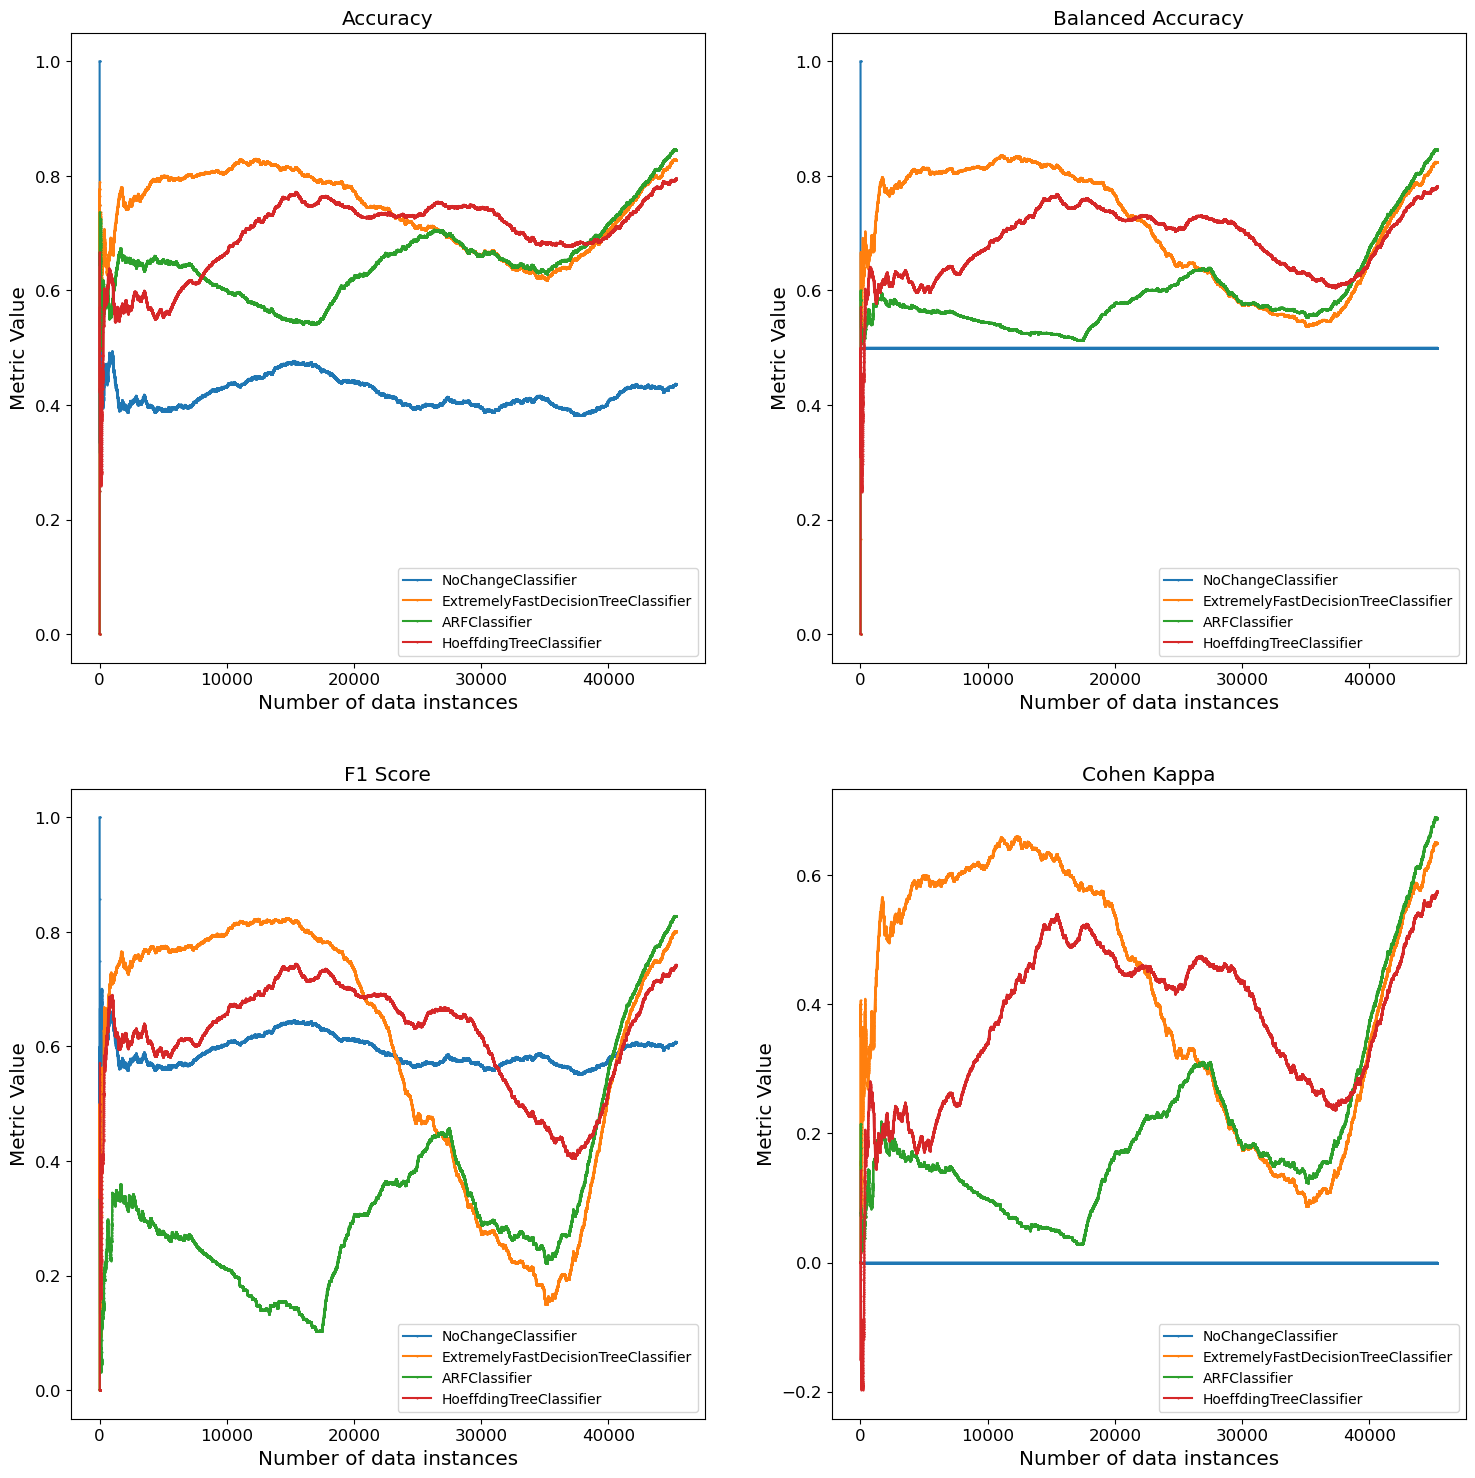

In [9]:
fig, axs = plt.subplots(2, 2)


axs[0, 0].plot(pdf.n, pdf.R_Accuracy, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_2, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_3, marker='.', markersize = 1)
axs[0, 0].plot(pdf.n, pdf.R_Accuracy_4, marker='.', markersize = 1)
axs[0,0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 0].set_title('Accuracy')

axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_2, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_3, marker='.', markersize = 1)
axs[0, 1].plot(pdf.n, pdf.R_BalancedAccuracy_4, marker='.', markersize = 1)
axs[0, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[0, 1].set_title('Balanced Accuracy')

axs[1, 0].plot(pdf.n, pdf.R_F1, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_2, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_3, marker='.', markersize = 1)
axs[1, 0].plot(pdf.n, pdf.R_F1_4, marker='.', markersize = 1)
axs[1, 0].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 0].set_title('F1 Score')

axs[1, 1].plot(pdf[pdf["R_CohenKappa"] >= -0.2].n, pdf[pdf["R_CohenKappa"] >= -0.2].R_CohenKappa, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_2"] >= -0.2].n, pdf[pdf["R_CohenKappa_2"] >= -0.2].R_CohenKappa_2, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_3"] >= -0.2].n, pdf[pdf["R_CohenKappa_3"] >= -0.2].R_CohenKappa_3, marker='.', markersize = 1)
axs[1, 1].plot(pdf[pdf["R_CohenKappa_4"] >= -0.2].n, pdf[pdf["R_CohenKappa_4"] >= -0.2].R_CohenKappa_4, marker='.', markersize = 1)
axs[1, 1].legend( ['NoChangeClassifier','ExtremelyFastDecisionTreeClassifier', 'ARFClassifier', 'HoeffdingTreeClassifier'], loc = 'lower right')
axs[1, 1].set_title('Cohen Kappa')


for ax in axs.flat:
    ax.set(xlabel='Number of data instances', ylabel='Metric Value')
#     handles, labels = ax.get_legend_handles_labels()
#     fig.legend(handles, labels, loc='upper center')
# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

### Final metrics on the whole data source - Evaluator

In [35]:
pdf.iloc[pdf.shape[0]-1,:]

training_time                                     21.190384
n                                                     45311
hostname                                   cluster-9e14-w-1
hash                                       whsrjs0q2s4xxp4p
model_name                               NoChangeClassifier
prediction                                              1.0
R_Accuracy                                           0.4364
R_BalancedAccuracy                                      0.5
R_F1                                                0.60763
R_CohenKappa                                            0.0
Accuracy                                           0.424533
BalancedAccuracy                                        0.5
F1                                                 0.596031
CohenKappa                                              0.0
model_name_2            ExtremelyFastDecisionTreeClassifier
prediction_2                                            0.0
R_Accuracy_2                            

**NoChange:**

-Accuracy                                           0.424533

-BalancedAccuracy                                        0.5

-F1                                                 0.596031

-CohenKappa                                              0.0

**EFTD:**

-Accuracy                                        **0.749972**

-BalancedAccuracy                                 **0.727608**

-F1                                               **0.663038**

-CohenKappa                                      **0.470785**

**ARF:**

-Accuracy                                        0.677098

-BalancedAccuracy                                 0.629494

-F1                                                0.45233

-CohenKappa                                       0.281556

**HT:**  

-Accuracy                                         0.723621

-BalancedAccuracy                                 0.707678

-F1                                               0.649068

-CohenKappa                                      0.423401



# Electricity 4 - Predictor

In [37]:
#SET TASK
task = {"cluster-9e14-w-0": {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"
                                                  ]},
        "cluster-9e14-w-1" : {"pretrained_models": ["NoChangeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ExtremelyFastDecisionTreeClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "ARFClassifier_cluster-9e14-w-1_45001.pkl",
                                                   "HoeffdingTreeClassifier_cluster-9e14-w-1_45001.pkl"]},
        'workers': ["cluster-9e14-w-0", "cluster-9e14-w-1"]}

data_cols = [field.name for field in input_schema.fields][:-1]
print(data_cols)
# data_cols = ['V' + str(i) for i in range(1,29)]
# data_cols.append('Amount') 

sm = stream_miner_master.StreamMinerMaster(data_cols, task)
output_schema = sm.output_schema

output_schema


['date', 'day', 'period', 'nswprice', 'nswdemand', 'vicprice', 'vicdemand', 'transfer']


StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('model_name_3', StringType(), False), StructField('prediction_3', DoubleType(), False), StructField('model_name_4', StringType(), False), StructField('prediction_4', DoubleType(), False)])

In [38]:
sm = predictor_master.PredictorMaster(data_cols, task)
output_schema = sm.output_schema

output_schema


StructType([StructField('training_time', FloatType(), False), StructField('n', IntegerType(), False), StructField('hostname', StringType(), False), StructField('hash', StringType(), False), StructField('model_name', StringType(), False), StructField('prediction', DoubleType(), False), StructField('model_name_2', StringType(), False), StructField('prediction_2', DoubleType(), False), StructField('model_name_3', StringType(), False), StructField('prediction_3', DoubleType(), False), StructField('model_name_4', StringType(), False), StructField('prediction_4', DoubleType(), False)])

In [39]:
sm.transform_and_collect(sdf, "/user/hdfs/evaluation/sm/e4", "/user/hdfs/evaluation/sm/e4/chk")

23/08/20 17:02:51 WARN ResolveWriteToStream: spark.sql.adaptive.enabled is not supported in streaming DataFrames/Datasets and will be disabled.
23/08/20 17:03:21 WARN ProcessingTimeExecutor: Current batch is falling behind. The trigger interval is 5000 milliseconds, but spent 29575 milliseconds
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/lib/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/opt/conda/miniconda3/lib/python3.10/socket.py", line 705, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [40]:
df = spark.read.format("csv").options(header='false').schema(output_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/evaluation/sm/e4")
pdf = df.toPandas()
pdf = pdf.sort_values(by=['n'])

print(pdf.shape)
print(np.max(pdf.training_time)) # seconds of training

print(np.max(pdf.n)) # seconds of training
np.unique(pdf.hash, return_counts=True)

(45311, 12)
10.947874
45311


(array(['vr3u0dmwvgk6xhsz'], dtype=object), array([45311]))

In [41]:
print(np.unique(pdf.prediction, return_counts = True))
print(np.unique(pdf.prediction_2, return_counts = True))
print(np.unique(pdf.prediction_3, return_counts = True))
print(np.unique(pdf.prediction_4, return_counts = True))

(array([1.]), array([45311]))
(array([0., 1.]), array([30926, 14385]))
(array([0., 1.]), array([37832,  7479]))
(array([0., 1.]), array([28862, 16449]))


In [43]:
14385/45311*100 # EFDT

31.74725784025954

In [44]:
7479/45311*100 # ARF

16.505925713402927

In [45]:
16449/45311*100 # HT

36.3024431153583

In [3]:
df = spark.read.format("csv").options(header='false').schema(input_schema). \
load("hdfs://cluster-9e14-m/user/hdfs/electricity")
pdf = df.toPandas()

In [5]:
np.unique(pdf.Class, return_counts=True)

(array([0., 1.]), array([26075, 19237]))

In [7]:
19237/(19237+26075)*100

42.45453742937853

# SM1 - Friedman ( regression)